# Originial Jets Plotter

In [1]:
%cd ..

/global/home/users/yifengh3/VAE/EMD_VAE


In [2]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K

import os
import os.path as osp
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools
from utils.VAE_model_tools import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle
from scipy.stats import gaussian_kde

1 Physical GPUs, 0 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [5]:
# path to file
fn =  '/global/home/users/yifengh3/VAE/data/B_background.h5'

df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi
data = df.values.reshape((-1,50,3))

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),50,4))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
# no input from energy for B jets
# sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data


train_x = data_x[:800000]
train_y = data_y[:800000]
valid_x = data_x[800000:]
valid_y = data_y[800000:]

(1000000, 150)
Memory in GB: 2.250075340270996


In [6]:
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis

def get_jet_plot(jet,numplot = 100, R=0.02,size=1000, save_dir = None): 
    """
    plots original jet and save as png file
    jet: Nonex50x3 jet input
    """
    for i in range(numplot):
        outjet = valid_y[i,:,1:]
        weights = valid_y[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        plt.scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        plt.title("validation data #{}".format(i+1))
        plt.xlim(-np.pi,np.pi)
        plt.ylim(-5,5)
        plt.ylabel(r'$\eta$',fontsize=18)
        plt.xlabel(r'$\phi$',fontsize=18)
        if save_dir:
            plt.savefig(os.path.join(save_dir, "original_jet_{}.png".format(i)))
        plt.show()

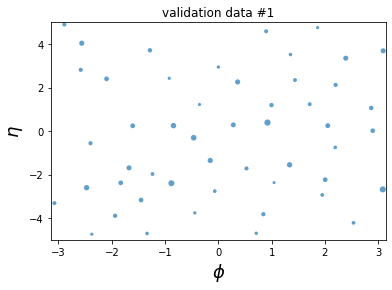

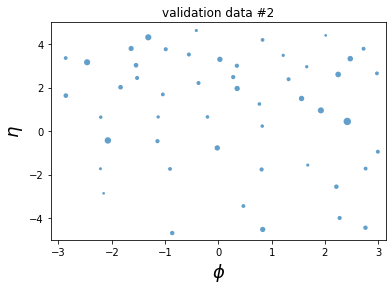

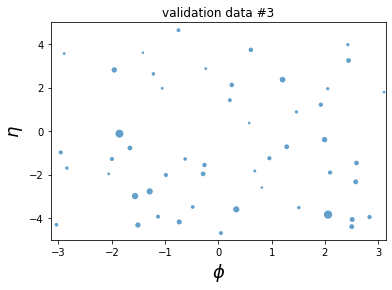

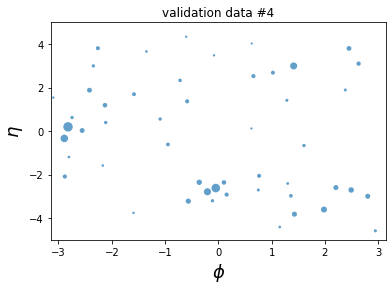

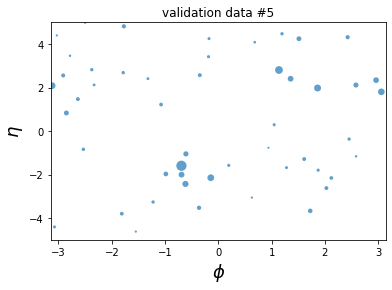

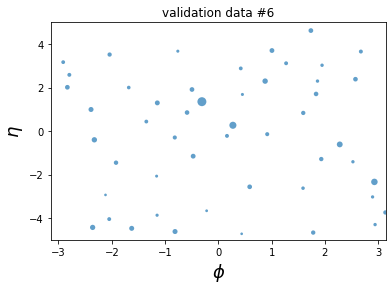

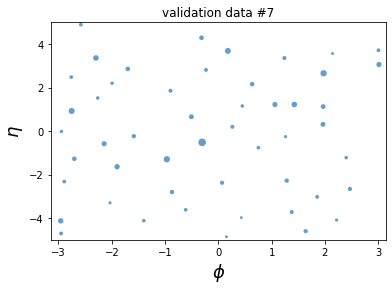

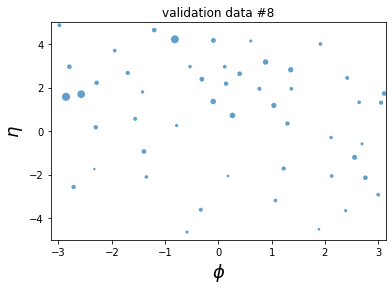

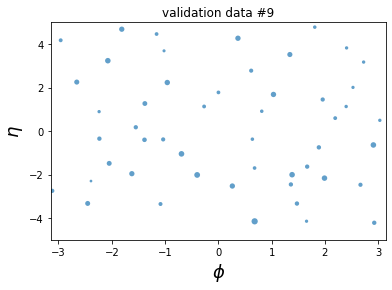

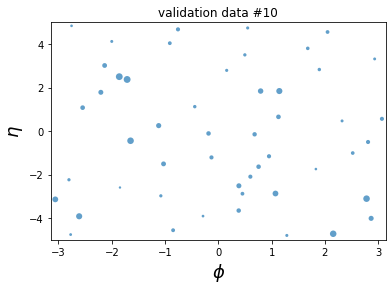

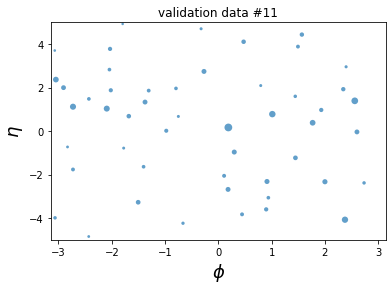

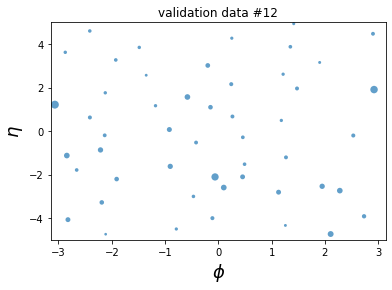

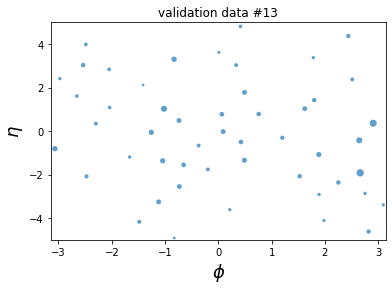

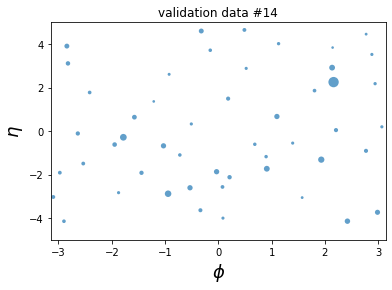

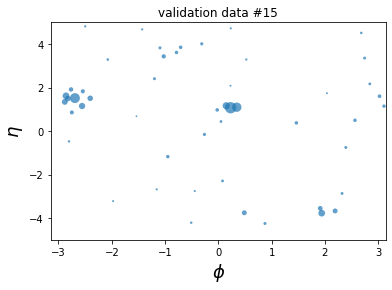

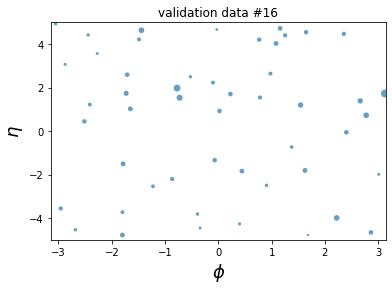

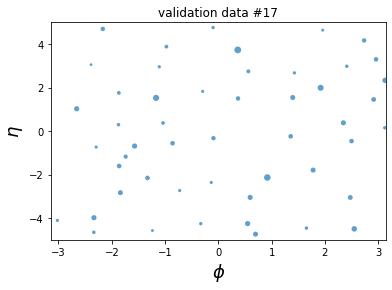

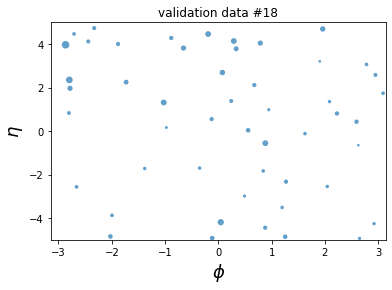

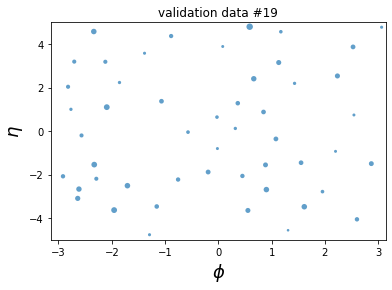

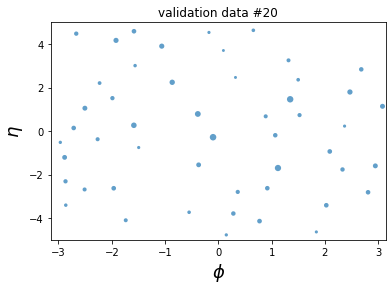

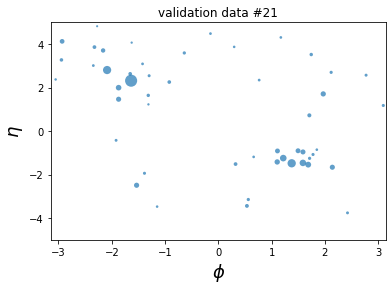

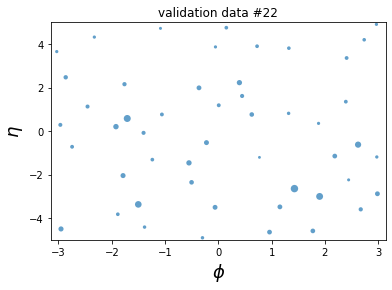

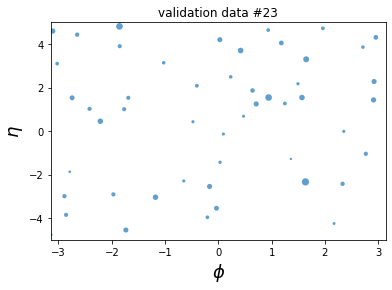

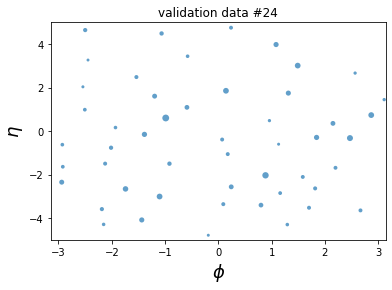

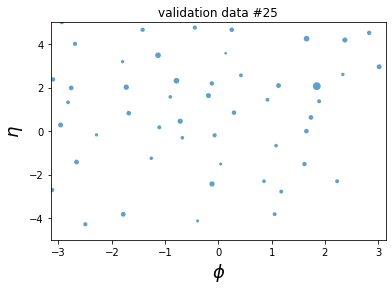

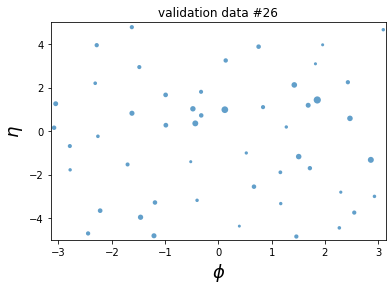

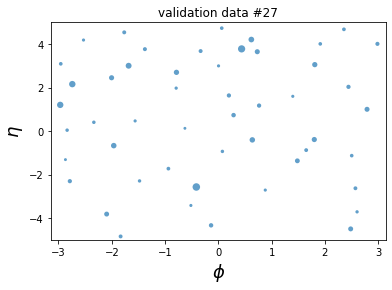

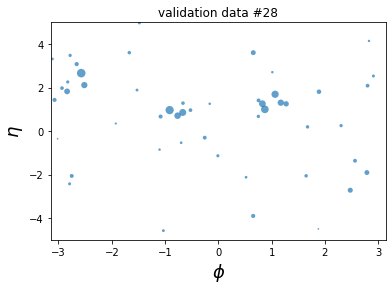

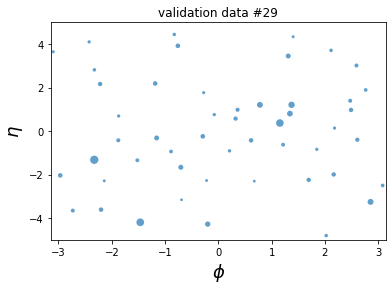

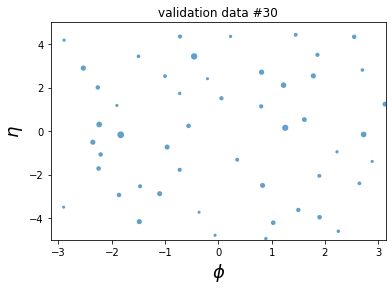

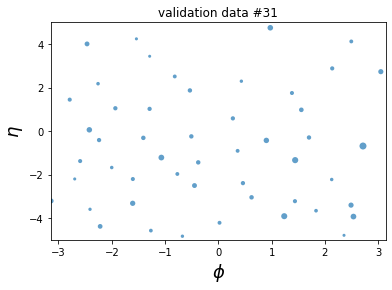

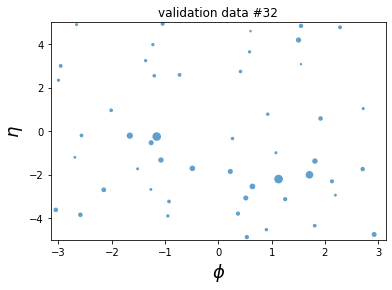

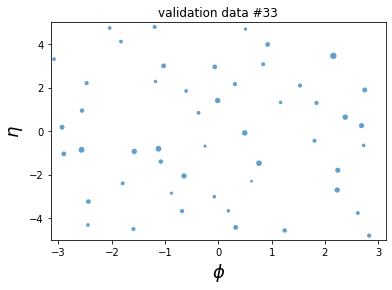

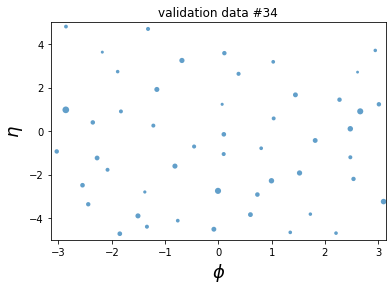

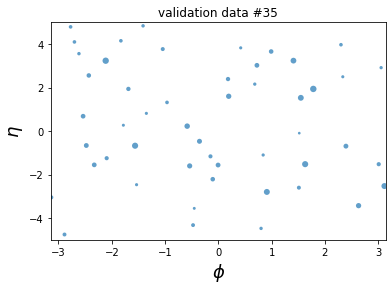

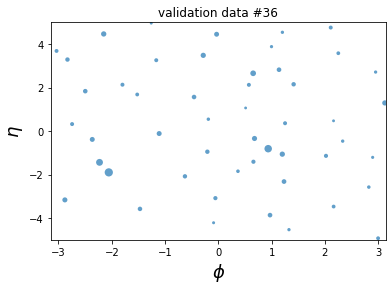

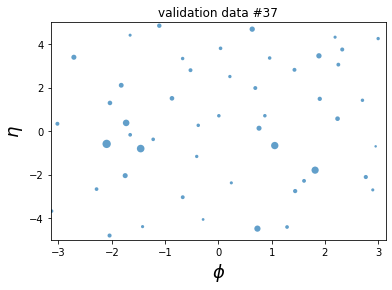

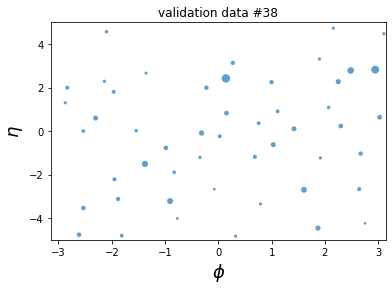

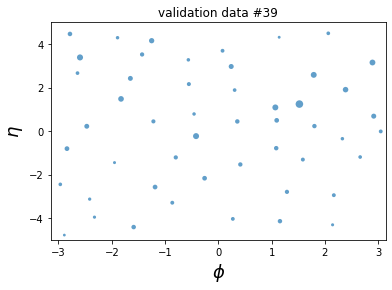

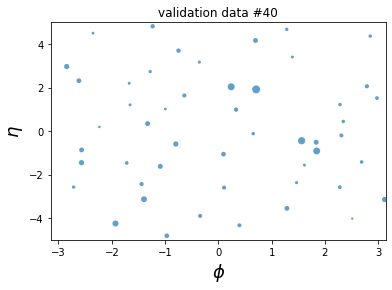

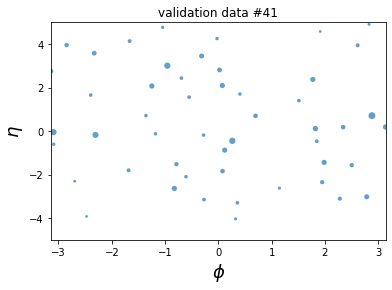

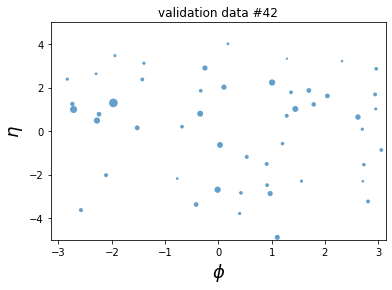

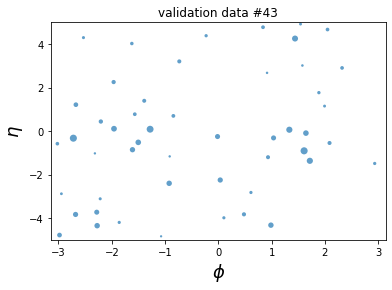

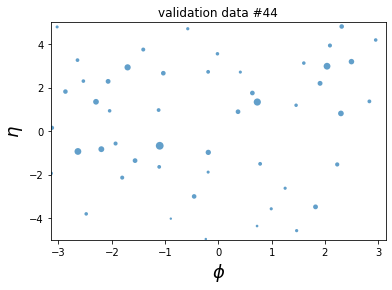

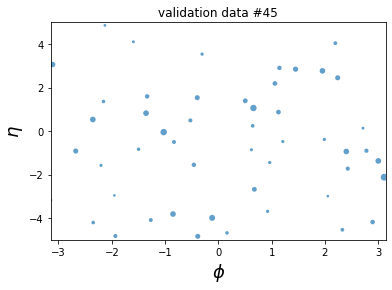

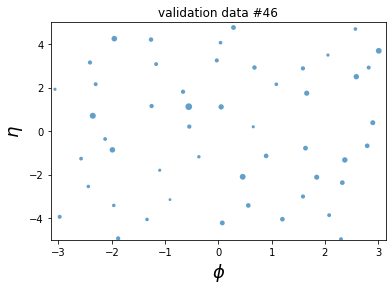

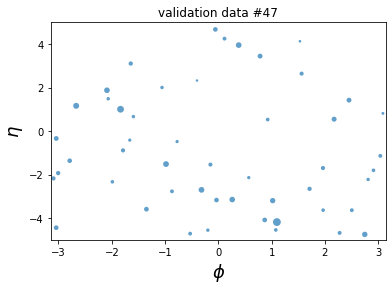

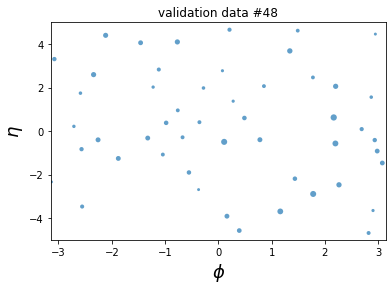

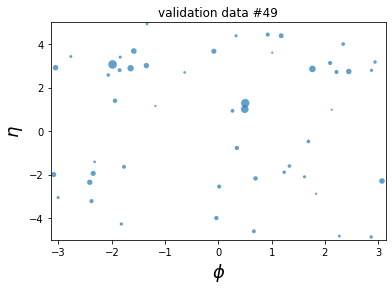

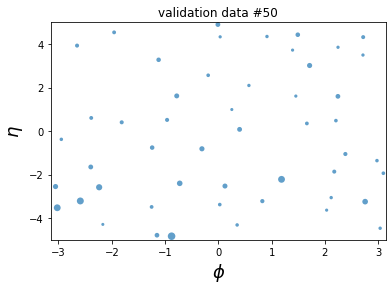

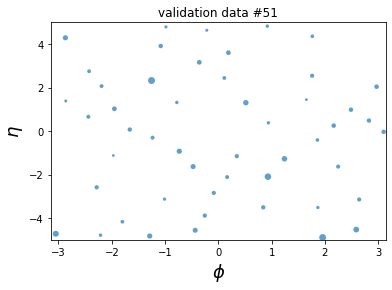

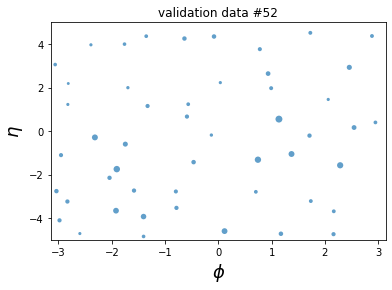

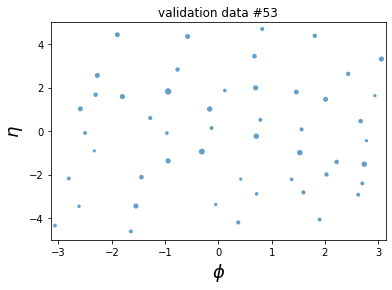

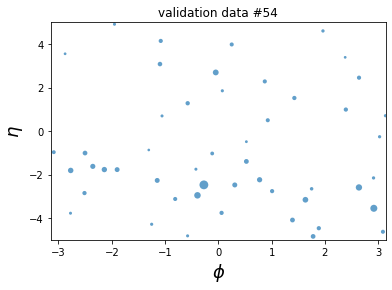

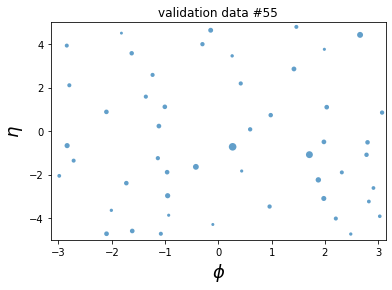

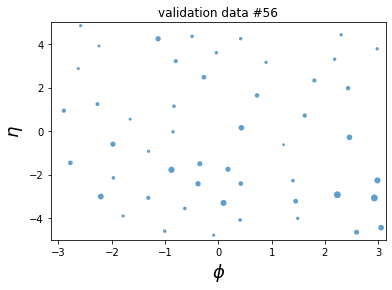

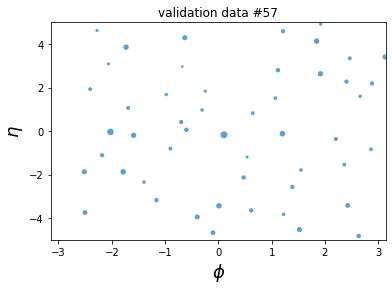

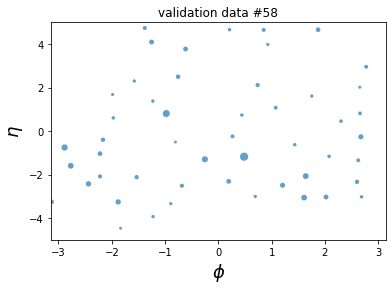

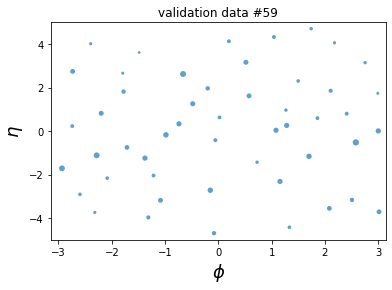

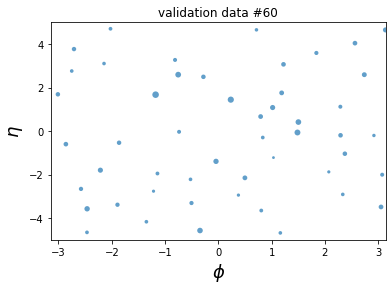

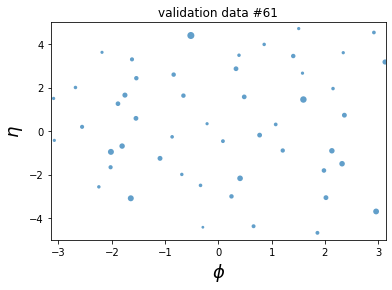

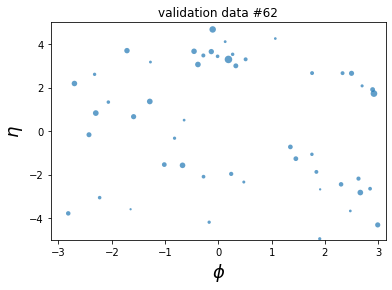

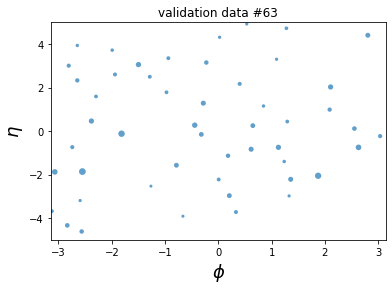

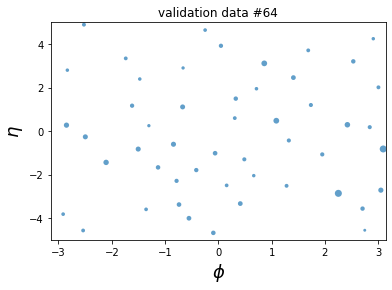

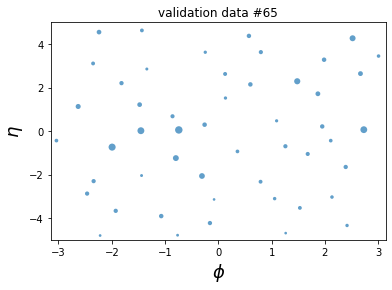

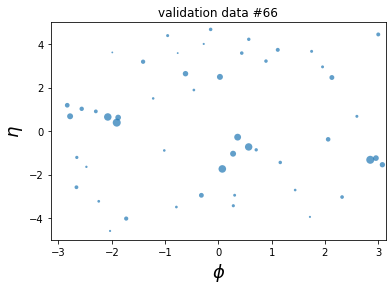

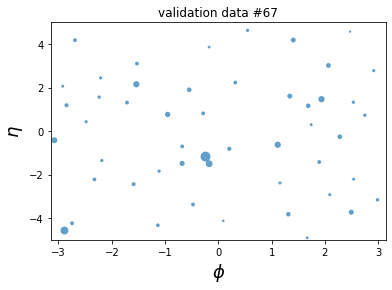

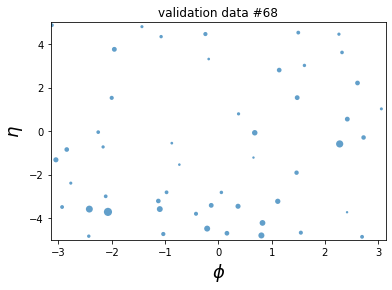

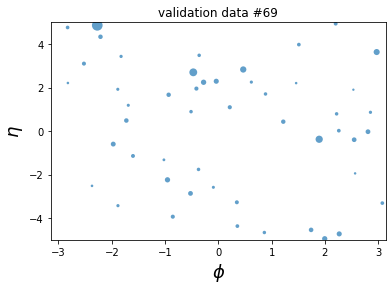

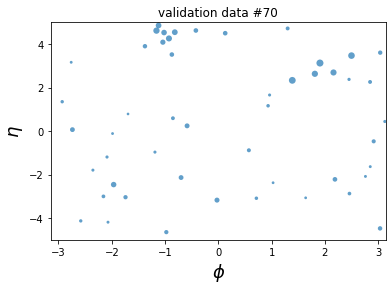

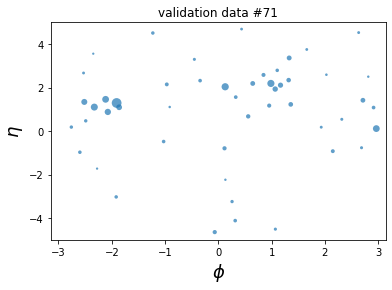

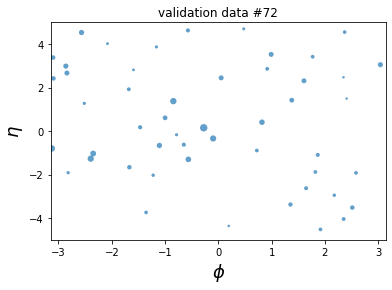

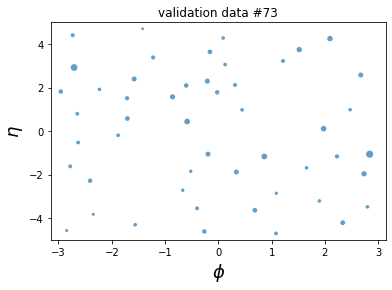

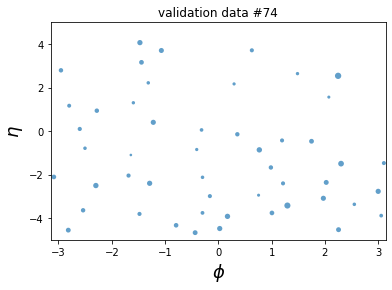

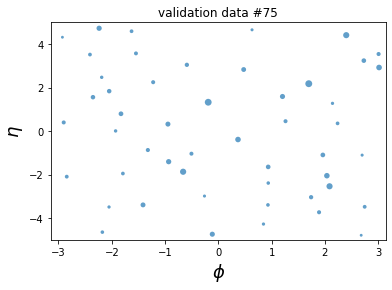

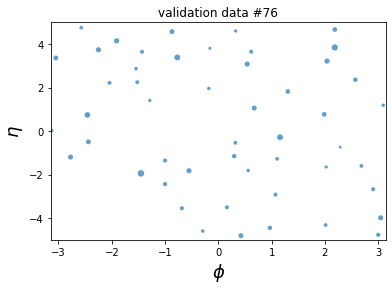

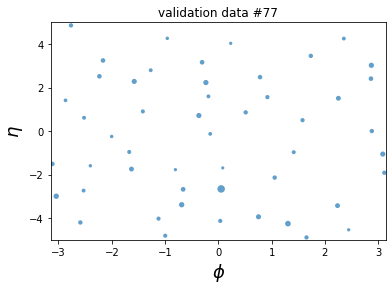

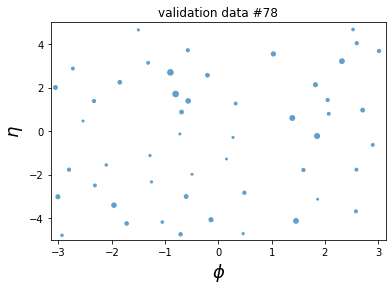

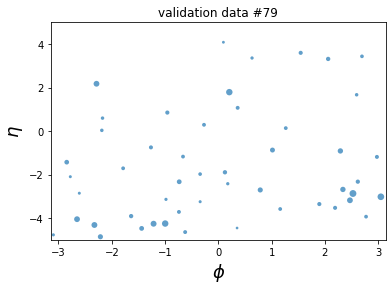

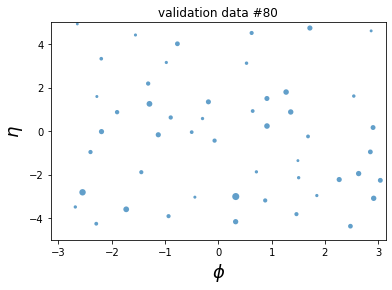

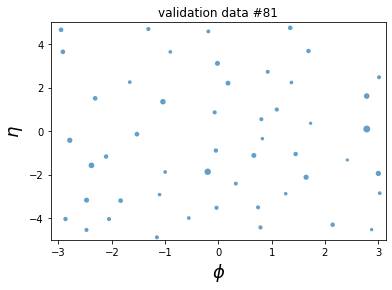

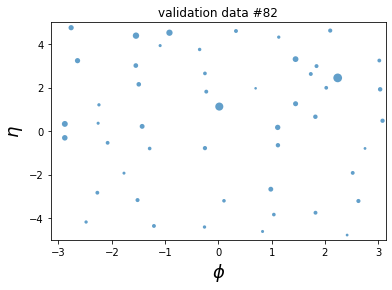

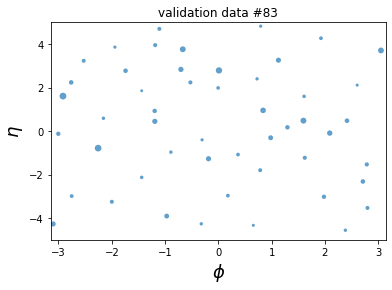

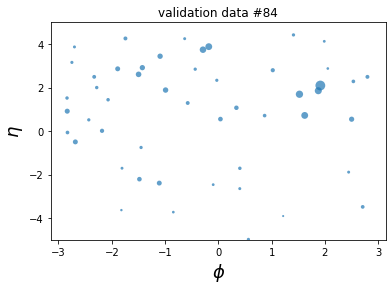

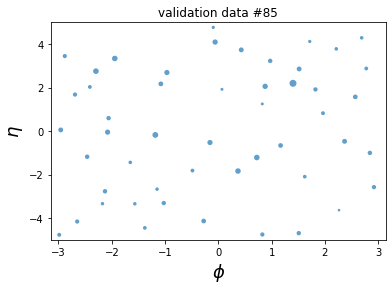

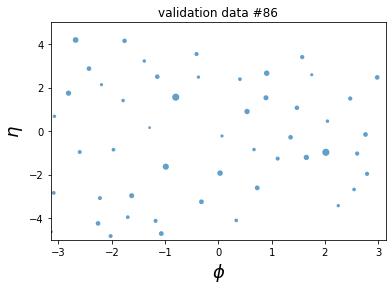

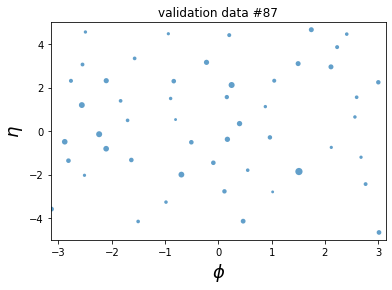

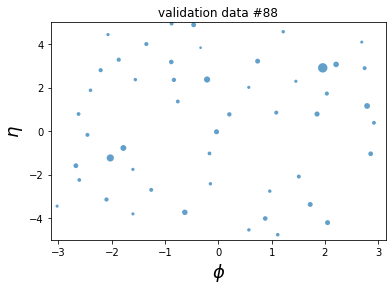

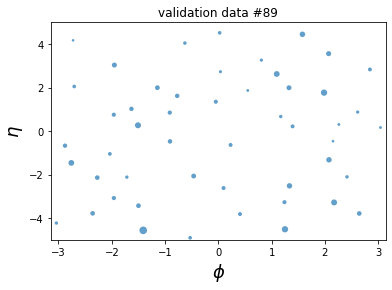

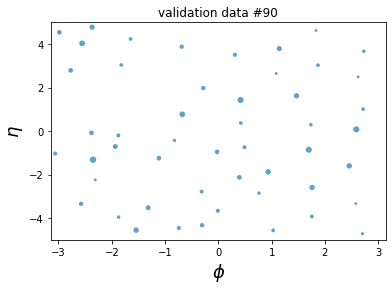

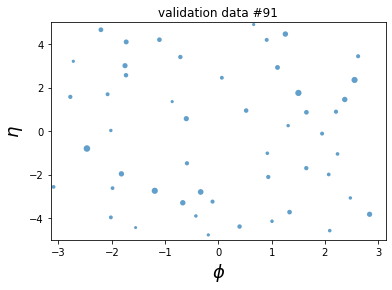

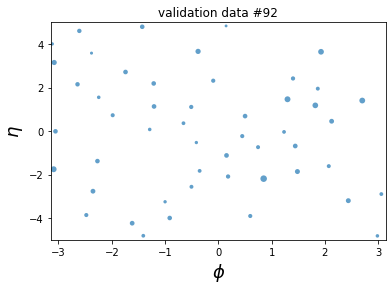

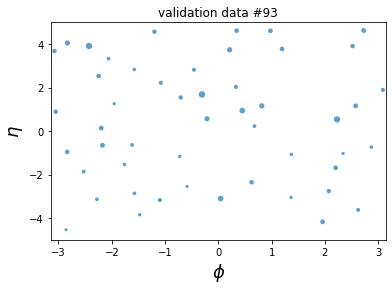

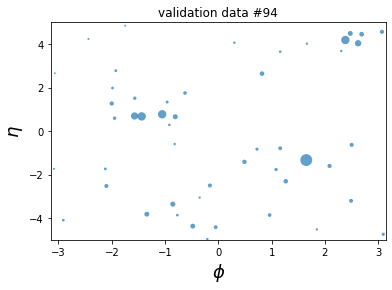

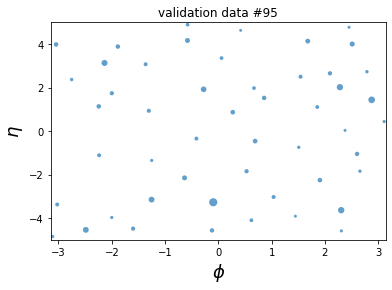

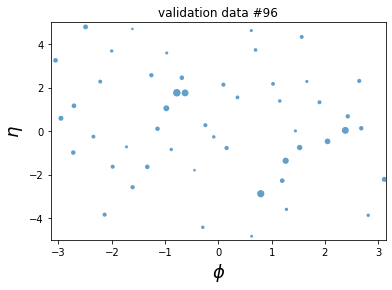

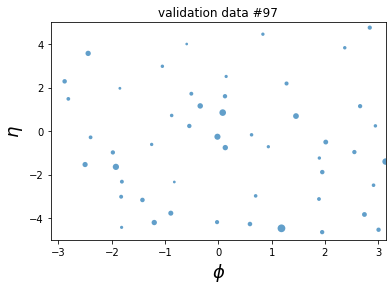

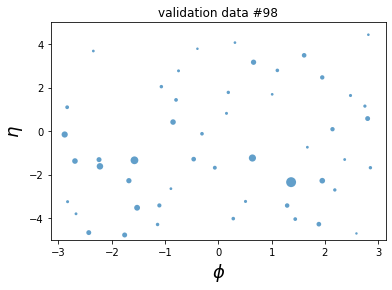

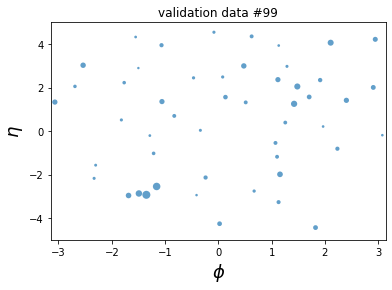

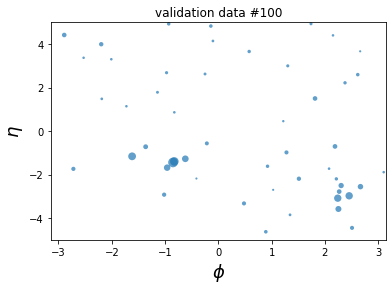

In [7]:
get_jet_plot(valid_y,100,save_dir="/global/home/users/yifengh3/VAE/data/background_visual")